In [ ]:
! pip install transformers
! pip install torchtext==0.6.0

     |████████████████████████████████| 2.0MB 11.8MB/s 
     |████████████████████████████████| 890kB 55.0MB/s 
     |████████████████████████████████| 3.2MB 49.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=b1cb8d113d08ea1b228802c32f1535cef2bfba057ee94c29c9538ba5f419458c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 71kB 7.0MB/s 
     |████████████████████████████████| 1.2MB 17.3MB/s 
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1


In [ ]:
import matplotlib.pyplot as plt #plot
import seaborn as sns #visualization
import pandas as pd #csv and df

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix #metrics and reporting

import torch
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator #Read csv + Batch iterator
from torchtext import data

#from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup #Tokenizer + Model + Adaptive LR + Schedule learning rate
from transformers import AutoTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

In [ ]:
# Set random seed and set device to GPU.
torch.manual_seed(999)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print('We will use the GPU:', torch.cuda.get_device_name(0))

We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
#Fine-tuning RoBERTa by Huggingface for Fake News classification.

data_path = '/content/drive/MyDrive/Homework2/datasets'
output_path = '/content/drive/MyDrive/Homework2/output/test2'
checkpoint_path = '/content/drive/MyDrive/Homework2/output/checkpoint'

In [ ]:
# Initialize tokenizer.
#tokenizer = RobertaTokenizer.from_pretrained("roberta-base") #roberta-base. Roberta-large too large for GPU
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased') #Scibert

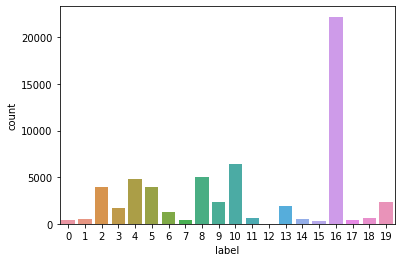

In [ ]:
df_train_merged = pd.read_csv('/content/drive/MyDrive/Homework2/datasets/df_train_merged.csv')
sns.countplot(x = 'label', data=df_train_merged)
#Missing : alculate weights of each class 1/nbrOfInstances

In [ ]:
# Set tokenizer hyperparameters.
MAX_SEQ_LEN = 300 # define max length  #300
BATCH_SIZE = 32 #Batch size at each iteration
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token) #For PAD_index, give pad token
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token) #For Unknown_index, give UNK token

# Define columns to read.
label_field = Field(sequential=False, use_vocab=False, batch_first=True) #Columns in Label
text_field = Field(use_vocab=False,  # Text pre-processing
                   tokenize=tokenizer.encode,  #Tokenized(encoded)
                   include_lengths=False,
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, #Length define max_sequence
                   pad_token=PAD_INDEX, # Padding
                   unk_token=UNK_INDEX) # Unknown words

fields = {'text' : ('text', text_field), 'label' : ('label', label_field)} # define fields titletext is text_field and label is label_field

#Read preprocessed CSV into TabularDataset and split it into train, test and valid.
train_data, valid_data = TabularDataset(path=f"{data_path}/df_train_merged.csv",   #test_data (REMOVED) #
                                                   format='CSV',
                                                   fields=fields,
                                                   skip_header=False).split(split_ratio=[0.999,0.001],  #0.90, 0.1
                                                                            stratified=True,
                                                                            strata_field='label')

# #FOR TEST (ADDED)
# train_data, valid_data, test_data  = TabularDataset(path=f"{data_path}/df_train_merged.csv",  #test_data
#                                                    format='CSV',
#                                                    fields=fields,
#                                                    skip_header=False).split(split_ratio=[0.70, 0.15, 0.15],
#                                                                             stratified=True,
#                                                                             strata_field='label')
# #Test iterator, no shuffling or sorting required.
# test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)




#Train data and valid data aren't used directly use Bucket/Batch iterator
# Create train and validation iterators.
train_iter, valid_iter = BucketIterator.splits((train_data, valid_data),  #
                                               batch_size=BATCH_SIZE,
                                               device=device,
                                               shuffle=True,
                                               sort_key=lambda x: len(x.text),
                                               sort=False, # CHANGED : sort=True,
                                               sort_within_batch=True)

In [ ]:
#kaggle test pre-processing
test_pd = pd.read_csv('/content/drive/MyDrive/Homework2/datasets/test.csv')
n2p_pd = pd.read_csv('/content/drive/MyDrive/Homework2/datasets/nodeid2paperid.csv')
text_pd = pd.read_csv('/content/drive/MyDrive/Homework2/datasets/text.csv')

#Join relevant data into one dataFrame
X_test_pd = pd.merge(test_pd, n2p_pd, on='node_id')
X_test_pd = pd.merge(X_test_pd, text_pd, on='paper_id')

# Transform title and abstract into one column
X_test_pd['text'] = X_test_pd['title'] + ". " + X_test_pd['abstract'] #Full original length

#delete irrelevant columns
del X_test_pd['abstract']
del X_test_pd['title']
del X_test_pd['paper_id']

X_test_pd.to_csv(f"{data_path}/test_node_text.csv")


In [ ]:
#kaggle test tokenizer and iterator
# Set tokenizer hyperparameters.
MAX_SEQ_LEN = 350 # define max length  #300
BATCH_SIZE = 1 #One by one can we increase safely ??
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token) #For PAD_index, give pad token
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token) #For Unknown_index, give UNK token

text_field = Field(use_vocab=False,  # Text pre-processing
                   tokenize=tokenizer.encode,  #Tokenized(encoded)
                   include_lengths=False,
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, #Length define max_sequence
                   pad_token=PAD_INDEX, # Padding
                   unk_token=UNK_INDEX) # Unknown words

field = {'text' : ('text', text_field)} # define fields titletext is text_field and label is label_field

test_data_kaggle = TabularDataset(path=f"{data_path}/test_node_text.csv",  #test_data
                                                   format='CSV',
                                                   fields=field,
                                                   skip_header=False)

test_iter_kaggle = Iterator(test_data_kaggle, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [ ]:
# Functions for saving and loading model parameters and metrics.
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}, path)


def load_checkpoint(path, model):
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])

    return state_dict['valid_loss']


def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}

    torch.save(state_dict, path)


def load_metrics(path):
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
# Model with extra layers on top of RoBERTa
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.05):
        super(ROBERTAClassifier, self).__init__()

        self.roberta = BertModel.from_pretrained('allenai/scibert_scivocab_uncased', return_dict=False) # Change?   :  RobertaForSequenceClassification + add linear layers ?
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 96) #768 + 96 hidden neurons
        self.bn1 = torch.nn.LayerNorm(96)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(96, 20)

    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)

        return x

In [ ]:
def pretrain(model,
             optimizer,
             train_iter,
             valid_iter,
             scheduler = None,
             valid_period = len(train_iter),
             num_epochs = 5): #6

    weights = [1, 1.2, 1, 1, 1, 1, 1, 1.2, 1, 1, 1, 1.2, 1.2, 1, 1, 1, 0.8, 1, 1, 1]
    class_weights = torch.FloatTensor(weights).cuda()

    # Pretrain linear layers, do not train bert
    for param in model.roberta.parameters():
        param.requires_grad = False #Roberta parameters fixed S

    model.train()

    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0
    global_step = 0

    # Train loop
    for epoch in range(num_epochs):
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)

            y_pred = model(input_ids=source,
                           attention_mask=mask)

            loss = torch.nn.CrossEntropyLoss(weight = class_weights)(y_pred, target) #Struggle to calculate the loss, problem here ??

            loss.backward()

            # Optimizer and scheduler step
            optimizer.step()
            scheduler.step()

            optimizer.zero_grad()

            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()

                with torch.no_grad():
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)

                        y_pred = model(input_ids=source,
                                       attention_mask=mask)

                        loss = torch.nn.CrossEntropyLoss(weight = class_weights)(y_pred, target)

                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)

                model.train()

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], PT Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),  #problem with global_step and num_epochs*len(train_iter)
                              train_loss, valid_loss))

                train_loss = 0.0
                valid_loss = 0.0

    # Set roberta parameters back to trainable
    for param in model.roberta.parameters():
        param.requires_grad = True #Unfreeze RoBERTa parameters

    print('Pre-training done!')

In [ ]:
#No validation verification

#Training function

def train(model, #ROBERTA
          optimizer, #AdamW
          train_iter, #BucketIterator train_iter
          valid_iter, #BucketIterator valid_iter
          scheduler = None,
          num_epochs = 5, #original 5
          valid_period = len(train_iter),
          output_path = output_path): #checkpoint_path = checkpoint_path

    weights = [1, 1.2, 1, 1, 1, 1, 1, 1.2, 1, 1, 1, 1.2, 1.2, 1, 1, 1, 0.8, 1, 1, 1]
    class_weights = torch.FloatTensor(weights).cuda()

    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    best_valid_loss = float('Inf')

    global_step = 0
    global_steps_list = []

    model.train()


    # Train loop
    for epoch in range(num_epochs):
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)

            y_pred = model(input_ids=source,
                           attention_mask=mask)

            loss = torch.nn.CrossEntropyLoss(weight = class_weights)(y_pred, target)

            loss.backward()

            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

            # Optimizer and scheduler step
            optimizer.step()
            scheduler.step()

            optimizer.zero_grad()

            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()

                with torch.no_grad():
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)

                        y_pred = model(input_ids=source,
                                       attention_mask=mask)
                        #output = model(input_ids=source,
                        #               labels=target,
                        #               attention_mask=mask)

                        loss = torch.nn.CrossEntropyLoss(weight = class_weights)(y_pred, target)
                        #loss = output[0]

                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                global_steps_list.append(global_step)

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))

                # torch.save({
                #         'epoch': epoch,
                #         'model_state_dict': model.state_dict(),
                #         'optimizer_state_dict': optimizer.state_dict(),
                #         'loss': train_loss_list}, checkpoint_path)


                # # checkpoint
                # if best_valid_loss > valid_loss:
                #     best_valid_loss = valid_loss
                #     save_checkpoint(output_path + '/model.pkl', model, best_valid_loss)
                #     save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)


                save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
                save_checkpoint(output_path + '/model.pkl', model, best_valid_loss)

                train_loss = 0.0
                valid_loss = 0.0
                model.train()






    print('Training done!')

In [ ]:
#Shorter epochs but more training data
NUM_EPOCHS = 7 #8
steps_per_epoch = len(train_iter)

model = ROBERTAClassifier()
model = model.to(device)

#load_checkpoint(output_path + '/model.pkl', model) # to restart previous training


optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=steps_per_epoch*1,
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

print("======================= Start pretraining ==============================")

pretrain(model=model,
         train_iter=train_iter,
         valid_iter=valid_iter,
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

NUM_EPOCHS = 8 #12 # crashed at epoch 4 -> not really right, change the size of bucket iterator and reset optimizer
print("======================= Start training =================================")
optimizer = AdamW(model.parameters(), lr=2e-6, weight_decay=0.01)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=steps_per_epoch*2,
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

train(model=model,
      train_iter=train_iter,
      valid_iter=valid_iter,
      optimizer=optimizer,
      scheduler=scheduler,
      num_epochs=NUM_EPOCHS ) #checkpoint_path = checkpoint_path


======================= Start pretraining ==============================
Epoch [1/7], global step [1874/13118], PT Loss: 1.9435, Val Loss: 1.3083
Epoch [2/7], global step [3748/13118], PT Loss: 1.2400, Val Loss: 0.9682
Epoch [3/7], global step [5622/13118], PT Loss: 1.0980, Val Loss: 0.9174
Epoch [4/7], global step [7496/13118], PT Loss: 1.0469, Val Loss: 0.8719
Epoch [5/7], global step [9370/13118], PT Loss: 1.0118, Val Loss: 0.8436
Epoch [6/7], global step [11244/13118], PT Loss: 0.9909, Val Loss: 0.8370
Epoch [7/7], global step [13118/13118], PT Loss: 0.9774, Val Loss: 0.8069
Pre-training done!
======================= Start training =================================
Epoch [1/8], global step [1874/14992], Train Loss: 0.7444, Valid Loss: 0.5552
Epoch [2/8], global step [3748/14992], Train Loss: 0.6011, Valid Loss: 0.4947
Epoch [3/8], global step [5622/14992], Train Loss: 0.5318, Valid Loss: 0.4781
Epoch [4/8], global step [7496/14992], Train Loss: 0.4851, Valid Loss: 0.4496
Epoch [5/

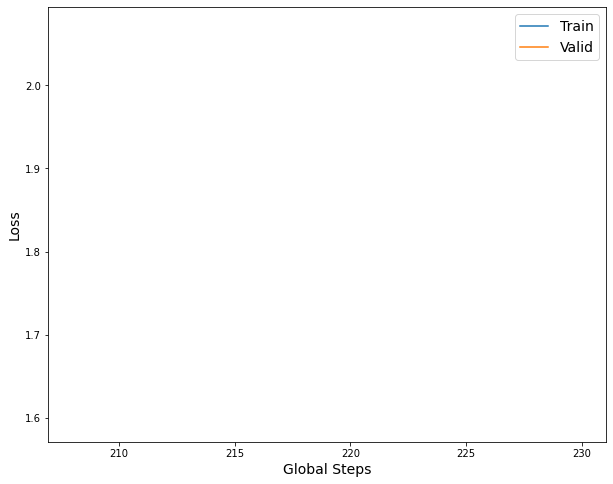

In [ ]:
#Finish training - Ploting Training and Validation loss
#Epoch : Full cycle through training data
#Step : One gradient update (relative to batching/bucket)

plt.figure(figsize=(10, 8))
train_loss_list, valid_loss_list, global_steps_list = load_metrics(output_path + '/metric.pkl')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()


In [ ]:
# Evaluation Function
#Was test dataset processed correctly ?

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (source, target), _ in test_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)

                output = model(source, attention_mask=mask)

                y_pred.extend(torch.argmax(output, axis=-1).tolist())
                y_true.extend(target.tolist())

    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
    ax = plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19'])
    ax.yaxis.set_ticklabels(['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19'])

Classification Report:
              precision    recall  f1-score   support

           0     0.8070    0.6765    0.7360        68
           1     0.6875    0.6548    0.6707        84
           2     0.9222    0.9377    0.9299       594
           3     0.8130    0.7968    0.8048       251
           4     0.8934    0.9444    0.9182       719
           5     0.9130    0.8750    0.8936       600
           6     0.7970    0.8214    0.8090       196
           7     0.8649    0.4638    0.6038        69
           8     0.9206    0.9461    0.9332       760
           9     0.9583    0.9280    0.9429       347
          10     0.8771    0.8862    0.8816       958
          11     0.7015    0.5054    0.5875        93
          12     0.0000    0.0000    0.0000         3
          13     0.7708    0.7973    0.7838       291
          14     0.8630    0.8514    0.8571        74
          15     0.7551    0.7400    0.7475        50
          16     0.9739    0.9748    0.9744      3333
    

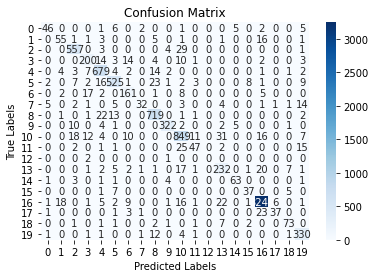

In [ ]:
model = ROBERTAClassifier()
model = model.to(device)

load_checkpoint(output_path + '/model.pkl', model)

evaluate(model, test_iter)

In [ ]:
# Evaluation Function
#Was test dataset processed correctly ?

def evaluateKaggle(model, test_loader):
    y_pred = []
    #y_true = []

    model.eval()
    with torch.no_grad():
        for (source), _ in test_loader: # ,target)
                mask = (source != PAD_INDEX).type(torch.uint8)

                output = model(source, attention_mask=mask)

                y_pred.extend(torch.argmax(output, axis=-1).tolist())
                #y_true.extend(target.tolist())
    return y_pred

    # print('Classification Report:')
    # print(classification_report(y_true, y_pred, labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], digits=4))

    # cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
    # ax = plt.subplot()

    # sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    # ax.set_title('Confusion Matrix')

    # ax.set_xlabel('Predicted Labels')
    # ax.set_ylabel('True Labels')

    # ax.xaxis.set_ticklabels(['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19'])
    # ax.yaxis.set_ticklabels(['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19'])

In [ ]:
model = ROBERTAClassifier()
model = model.to(device)

load_checkpoint(output_path + '/model.pkl', model)

predictions = evaluateKaggle(model, test_iter_kaggle)

In [ ]:
test_node_text = pd.read_csv('/content/drive/MyDrive/Homework2/datasets/test_node_text.csv')
label = pd.Series(predictions)
test_node_text['label'] = label

#delete irrelevant columns
del test_node_text['Unnamed: 0']
del test_node_text['text']

#rename
test_node_text.rename(columns={'node_id': 'id', 'label': 'label'}, inplace=True)

#save results
test_node_text.to_csv(f"{output_path}/kaggle_predictions_SciBert2.csv", index=False)

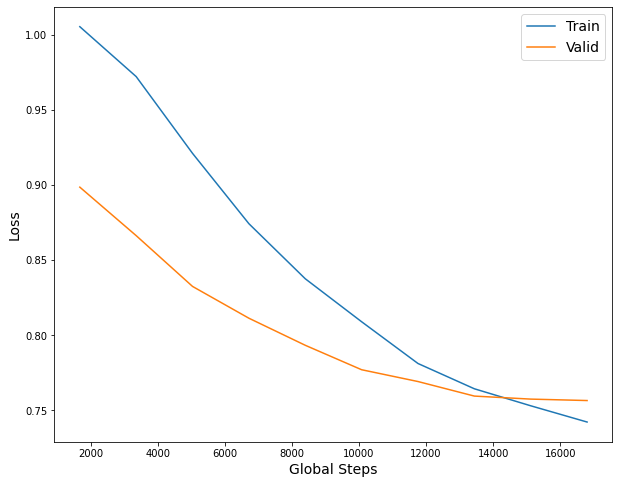

In [ ]:
#Finish training - Ploting Training and Validation loss
#Epoch : Full cycle through training data
#Step : One gradient update (relative to batching/bucket)

plt.figure(figsize=(10, 8))
train_loss_list, valid_loss_list, global_steps_list = load_metrics(old_output_path + '/metric.pkl')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()



Classification Report:
              precision    recall  f1-score   support

           0     0.7949    0.4559    0.5794        68
           1     0.0000    0.0000    0.0000        84
           2     0.8320    0.8586    0.8451       594
           3     0.6523    0.6653    0.6588       251
           4     0.8434    0.9360    0.8873       719
           5     0.8420    0.8617    0.8517       600
           6     0.7013    0.5510    0.6171       196
           7     0.0000    0.0000    0.0000        69
           8     0.8794    0.9211    0.8997       760
           9     0.8450    0.8329    0.8389       347
          10     0.7855    0.8257    0.8051       958
          11     0.0000    0.0000    0.0000        93
          12     0.0000    0.0000    0.0000         3
          13     0.7315    0.6460    0.6861       291
          14     0.8036    0.6081    0.6923        74
          15     1.0000    0.3400    0.5075        50
          16     0.9340    0.9886    0.9605      3333
   

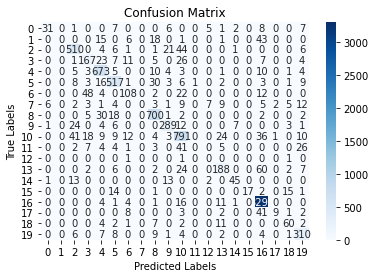

In [ ]:
#Print old model

old_output_path = '/content/drive/MyDrive/Homework2/output/'

model = ROBERTAClassifier()
model = model.to(device)

load_checkpoint(old_output_path + '/model.pkl', model) # to restart previous training

evaluate(model, test_iter)
